# 1. Updates (Check updates)

In [1]:
#import essential libraries 
import requests              #for api request
import pandas as pd
from datetime import datetime, timedelta

#method to get the current url
def get_url(page_number):    
    page = str(page_number)   
    url = 'https://api.stackexchange.com/2.2/questions?page=' + page + '&pagesize=100&order=desc&sort=activity&site=datascience'; 
    return url

#method to check api response validity
def response_validity(api_response):
    try:
        api_status = int(api_response.status_code)
    except ValueError:
        return None
    return True

#method to convert json to dataframe
def json_to_df(api_response):
    data = api_response.json()    
    try:
        df = pd.json_normalize(data['items'])
    except KeyError:
        return None
    df2 = df['tags']
    return df2
    
def update_records():   
    #variable to check no. of entries and df obj. to keep the records
    page_number=1
    records = pd.DataFrame()

    #to receive the required 10000 records from the api
    while page_number<=100:    
        url = get_url(page_number);
        api_response = requests.get(url)   

        #exception handling for failure of call response
        if response_validity(api_response) is None:
            continue

        #converting json to df obj.
        df2 = json_to_df(api_response)    

        #exception handling for error message from the server
        if df2 is None:
            break

        #adding rows to already existing records
        frames = [records, df2]
        records = pd.concat(frames, ignore_index=True)
        page_number+=1;

    #check for missing data for non empty df. object  
    if not records.empty:
        records.columns = ['tags']

    #update the records    
    records.to_csv('Data/tags.csv')

def update_now(now):
    update_records()
    file = open('Data\dateinfo.txt','w')
    new_update = now.strftime('%d/%m/%y %H:%M:%S')
    file.write(new_update)
    file.close()
    
def check_updates():
    now = datetime.now() # current date and time

    try:
        file = open('Data\dateinfo.txt','r')
        update_time = datetime.strptime(file.read(), '%d/%m/%y %H:%M:%S')
        file.close()
    except(FileNotFoundError, ValueError):
        update_now(now)
        update_time = datetime.strptime(file.read(), '%d/%m/%y %H:%M:%S')
        return True

    time_delta = (now - update_time)
    hours_elapsed = time_delta.total_seconds()/3600

    if hours_elapsed > 168:
        update_now(now)
        return True
        
    return False

*check updates*

In [2]:
from datetime import datetime

In [37]:
start_time = datetime.now()
check_updates()
time_delta = datetime.now() - start_time
print('time taken to check updates: {:.2f} secs'.format(time_delta.total_seconds()))

time taken to check updates: 119.859 secs


*It took 119.859 secs for a successful update.*

# 2. Modules (get_rows, create_graph, graph_query, train_word2vec, word2vec_query)

In [4]:
#import essential libraries
import ast                  #for text processing
import itertools
import collections
from collections import Counter
import networkx as nx      #networkx for w. graph
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors   #for word vector training

def get_rows(records):
    #save the dataframe as a list of row lists
    rows_list = []
    
    i=0
    while i < len(records.index):
        row = str(records.iloc[i,0])
        row = ast.literal_eval(row) 
        rows_list.append(row)
        i = i + 1
        
    return rows_list


def create_graph():
    #read records (step can be skipped if API call was executed beforehand)
    records = pd.read_csv('Data/tags.csv',index_col=0)
    
    #get the info stored in each row as a list
    rows_list = get_rows(records)
    
    #combine all the tags in a single list
    rows_concat = list(itertools.chain.from_iterable(rows_list))
    counts = collections.Counter(rows_concat)
    
    #remove term frequency from the dictionary (there may be other uses to it though)
    key_tags = list(counts.keys())
        
    #create a new weighted graph
    G=nx.Graph() 

    #add nodes for each of the key tags 
    G.add_nodes_from(key_tags)

    #create or change edge weights based on prior condition/value 
    #for between cluster of the key tags
    for row in rows_list:
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                if G.has_edge(row[i],row[j]):
                    G[row[i]][row[j]]['weight'] = G[row[i]][row[j]]['weight'] + 1
                else:
                    G.add_edge(row[i],row[j], weight=1)
                    
    return G
        
#method to return list of tags which are related to a search query 
#version 2.1, handles multiple tags
def graph_query(G, key_tag):
    word_split = str(key_tag).split()
    sum_dict = {}

    for word in word_split:
        temp_dict = {}
        edges = list(G.edges(word.lower())) #returns a list of all the edges from EdgeDataView

        for edge in edges:
            x = G.get_edge_data(edge[0],edge[1])
            temp_dict[edge[1]] = x['weight']

        sum_dict = dict(Counter(sum_dict) + Counter(temp_dict))       

    if sum_dict:
        result = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)
        result = [item[0] for item in result]
        result = result[:10]
        result = ' | '.join(result)
        
    else:
        result = 'No results match your search query'
        
    return result    

def train_word2vec():
    #read records (step can be skipped if API call was executed beforehand)
    records = pd.read_csv('Data/tags.csv',index_col=0)
    
    #get the info stored in each row as a list
    rows_list = get_rows(records)
    
    #train a new word vector model using gensim's word2vec, model saved for future use
    model = Word2Vec(rows_list,min_count=5,size=512,window=10,iter=40)
    model.wv.save("Data/wordvectors.kv")
    
def word2vec_query(tag):
    word_vectors = KeyedVectors.load("Data/wordvectors.kv", mmap='r')
    try:
        result = word_vectors.most_similar(tag.lower())
        result = [item[0] for item in result]
        result = ' | '.join(result)
    except:
        result = 'Tag wasn\'t included in the limited training set based on data science site from stack exchange'
        
    return result

*Read documents*

# 3. Brute-force recommendation based on Weighted-graph

In [5]:
graph = create_graph() 

if check_updates():         #I have decided data update through API call 
    graph = create_graph()  #is not so often required (only once in a week)

print(graph_query(graph, 'bigdata')) 

machine-learning | data-mining | dataset | data | python | apache-spark | r | deep-learning | data-cleaning | pyspark


# 4. Word2vec based recommendation

In [6]:
if check_updates():
    train_word2vec()

print(word2vec_query('bigdata'))

data-engineering | data | apache-hadoop | twitter | web-scraping | json | databases | scraping | pyspark | mongodb


# Comparison

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


Results for searching 'deep-learning': 

a) In stack-exchange                  b) Using weighted-graph                   c) Using word2vec


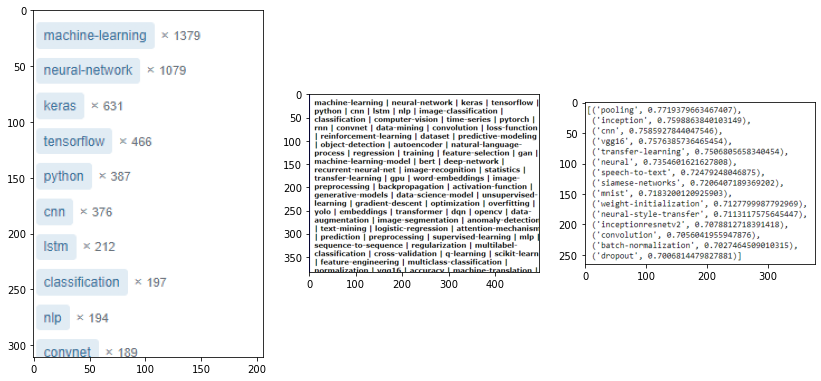

In [42]:
print('Results for searching \'deep-learning\': \n\na) In stack-exchange                  b) Using weighted-graph                   c) Using word2vec')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 8, forward=True)
fig.add_subplot(1,3,1)
img=mpimg.imread('Data\stack-exchange2.png')
imgplot = plt.imshow(img)
fig.add_subplot(1,3,2)
img=mpimg.imread('Data\graph.png')
imgplot = plt.imshow(img)
fig.add_subplot(1,3,3)
img=mpimg.imread('Data\word2vec.png')
imgplot = plt.imshow(img)
plt.show()

# Conclusion
1.Stack-exchange provides a brute-force based recommendation system. This was found to be evident even though limited data-set was used for creating the custom weighted-graph (only ten-thouthand documents).

2.Word2vec method returned much more insightful when compared to the graph algorithm even beyond expectations.

3.Both the used methods work only on the limited data used.

4.The graph algorithm was made to be more vocabulary rich by splitting hyphen separated words during the preprocessing . Whereas word2vec method didn't return results for some tag inquiries very close to what was given in the given documents (e.g. datascience).

5.Word2vec model changes in every new training although the training data was kept unchanged.

# Next steps

* Train word2vec model on bigrams and phrases